# Quantum Teleportation

In [33]:
import os
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from PIL import Image

def save_circuit_diagram(circuit, filename, folder='report/img', dpi=300, 
                         save_color=True, save_grayscale=True, 
                         style=None, return_figure=True):
    """
    Draw and save a quantum circuit diagram in color and/or grayscale formats.
    
    Args:
        circuit (QuantumCircuit): The quantum circuit to draw
        filename (str): Base filename without extension
        folder (str): Directory to save images (will be created if it doesn't exist)
        dpi (int): Resolution of the saved images
        save_color (bool): Whether to save the color version
        save_grayscale (bool): Whether to save the grayscale version
        style (dict): Optional style dictionary for the circuit drawing
        return_figure (bool): Whether to return the matplotlib figure
        
    Returns:
        The matplotlib figure object if return_figure is True
    """
    # Create the directory if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    
    # Full paths for the files
    color_path = os.path.join(folder, f"{filename}_color.png")
    gray_path = os.path.join(folder, f"{filename}_grayscale.png")
    
    # Draw the circuit
    if style:
        try:
            fig = circuit.draw(output="mpl", style=style)
        except Exception as e:
            print(f"Style error: {e}. Falling back to default style.")
            fig = circuit.draw(output="mpl")
    else:
        fig = circuit.draw(output="mpl")
    
    # Save color version if requested
    if save_color:
        fig.savefig(color_path, dpi=dpi, bbox_inches='tight')
        print(f"Saved color circuit diagram to {color_path}")
    
    # Save grayscale version if requested
    if save_grayscale:
        # Save temporary color version if we're not keeping it
        temp_path = color_path if save_color else os.path.join(folder, f"{filename}_temp.png")
        if not save_color:
            fig.savefig(temp_path, dpi=dpi, bbox_inches='tight')
        
        # Convert to grayscale using PIL
        img = Image.open(temp_path).convert('L')
        img.save(gray_path)
        print(f"Saved grayscale circuit diagram to {gray_path}")
        
        # Delete temporary file if we created one
        if not save_color:
            os.remove(temp_path)
    
    # Close the figure to free memory unless we're returning it
    if not return_figure:
        plt.close(fig)
    
    return fig if return_figure else None

## 1. Introduction and background

Quantum teleportation is a technique in quantum physics that allows the transfer of quantum information from one location to another without physically moving particles. Unlike the sci-fi concept of teleportation, this process doesn't involve transporting matter. Instead, it relies on the principle of quantum entanglement, where two particles become linked regardless of distance. Through a series of precise measurements and classical communication, the quantum state of one particle can be recreated in another particle at a distant location, effectively "teleporting" the quantum information. In this module, we'll see how this works mathematically, and then we will implement quantum teleportation on a real quantum computer. The introduction here will be brief; for more background on quantum information, and more explanation about teleportation, we recommend John Watrous's course on the [Basics of Quantum Information](https://learning.quantum.ibm.com/course/basics-of-quantum-information), and in particular the section on [Teleportation.](https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action#teleportation)

Classical bits can be in states 0 or 1. Quantum bits (qubits) can be in quantum states denoted $|0\rangle$ and $|1\rangle$ and also linear combinations of these states, called "superpositions", such as $|\psi\rangle = \alpha_0|0\rangle +\alpha_1|1\rangle$, with $\alpha_0,\alpha_1 \in \mathbb{C},$ and $|\alpha_0|^2+|\alpha_1|^2 = 1.$ Although the states can exist in this superposition, a measurement of the state will "collapse" it into either the $|0\rangle$ or $|1\rangle$ states. The parameters $a$ and $b$ are related to the probability of each measurement outcome according to

$$P_0 = |\alpha_0|^2$$
$$P_1 = |\alpha_1|^2$$

Hence the constraint that $|\alpha_0|^2+|\alpha_1|^2 = 1.$

Another key feature is that quantum bits can be "entangled", which means that the measurement of one qubit can affect the outcome of the measurement of another, entangled qubit. Understanding how entanglement is different from simple classical correlations is a bit tricky. Let's first explain our notation. Call two qubits belonging to friend 0 (Alice) and friend 1 (Bob), and each in the $|0\rangle$ state
$$|0\rangle_B|0\rangle_A$$ 
or 
$$|0\rangle_1|0\rangle_0$$ 
sometimes shortened to simply
$$|00\rangle.$$
Note that the lowest-numbered (or lettered) qubit is furthest to the right. This is a convention called "little-endian" notation, used throughout Qiskit.
If the two-qubit state of the friends is $|00\rangle,$ and they measure the state of their respective qubits, they will each find a 0. Similarly if the qubits were in the state $|11\rangle,$ each of their measurements would yield a 1. That is no different from the classical case. However, in quantum computing, we can combine this with superposition to obtain states like

$$\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$$

In a state like this, whether Alice and Bob have qubits in the state 0 or 1 is not yet known, not even yet determined by nature, and yet we know they will measure the same state for their qubit. For example, if Bob measures his qubit to be in the state $|0\rangle,$ the only way for that to happen is if the measurement has collapsed the two-qubit state to one of the two possible states, specifically to $|00\rangle.$ That leaves Alice's qubit also in the $|0\rangle$ state.

The entangled of qubits in this way does not require that the qubits remain physically close to one another. In other words, we could entangle qubits, then separate them by a large distance, and use their entanglement to send information. An entangled state like the one above is a basic unit of entanglement, and is sometimes referred to as an "e-bit", a single bit of entanglement. These e-bits can be thought of as resources in quantum communication, since each e-bit shared between distant partners can be used, as we outline here, to move information from one location to another.

The first thought for many people learning about this for the first time is about violating relativity: can we use this to send information faster than light? By all means, keep questioning and probing scientific rules, but unfortunately this won't allow us to send information faster than light, for reasons that will become clear through the course of this module. Spoiler: amazingly it is NOT due to the speed at which this collapse propagates, which does appear to happen faster than light[1](https://www.nature.com/articles/nature15759)

We start with two collaborators Alice and Bob, who are initially in the same location and can work together on the same qubits. These collaborators will entangle their qubits. Then they will move apart to two different geographic locations, bringing their respective qubits with them. Alice will then obtain quantum information on a new qubit Q. We make no assumptions about the information on Q. The state of Q could be a secret unknown to Alice; it could be unknown to all people. But Alice is given the task of transferring the information on Q to Bob. She will do this using quantum teleportation.

To accomplish this, we will need to know some quantum operations or "gates".

## 2. Quantum operators (gates)

Feel free to skip this section if you are already familiar with quantum gates. If you want to understand these gates better, check out [Basics of Quantum Information](https://learning.quantum.ibm.com/course/basics-of-quantum-information), especially the first two lessons, on the IBM Quantum Learning platform.

For this teleportation protocol we will primarily use two types of quantum gates: the Hadamard gate, the CNOT gate. A few others will play a lesser role: the $X$ gate, $Z$ gate, and the SWAP gate.

This module can be completed with very limited linear algebra background, but sometimes visualizing quantum mechanical gates using matrices and vectors can be helpful. So we present here the matrix/vector forms of quantum gates/states, as well.

The states we have already presented are chosen (partly by convention and partly by constraints) to have vector forms:
$$|0\rangle = \begin{pmatrix}1 \\ 0\end{pmatrix}$$
$$|1\rangle = \begin{pmatrix}0 \\ 1\end{pmatrix}$$
In this way, an arbitrary state $|\psi\rangle = a|0\rangle+b|1\rangle$ can be written as 
$$|\psi\rangle =\begin{pmatrix}a \\ b\end{pmatrix}$$

There is some choice in how to extend the notation to multiple-qubit states, but the choice below is quite standard:

$$|00\rangle = \begin{pmatrix}1 \\ 0 \\ 0 \\ 0\end{pmatrix},|01\rangle = \begin{pmatrix}0 \\ 1 \\ 0 \\ 0\end{pmatrix},
|10\rangle = \begin{pmatrix}0 \\ 0 \\ 1 \\0\end{pmatrix},|11\rangle = \begin{pmatrix}0 \\ 0 \\ 0 \\ 1\end{pmatrix}.$$

With this choice of vector notation in mind, we can introduce our needed quantum gates, their effects on quantum states, and their matrix forms.

__H Hadamard Gate:__ Creates a superposition state. Single-qubit gate.
$$H|0\rangle = \frac{1}{2}\left(|0\rangle+|1\rangle\right),$$
$$H|1\rangle = \frac{1}{2}\left(|0\rangle-|1\rangle\right)$$
$$H=\frac{1}{2}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$$

A circuit with a Hadamard gate is made as follows:


In [2]:
from qiskit import QuantumCircuit
qc=QuantumCircuit(1)
qc.h(0)
qc.draw("latex")

__CNOT Controlled-NOT Gate:__ This gate uses two qubits: a control and a target. Checks the state of a control qubit which is not changed. But if the control qubit is in the state $|1\rangle$, the gate changes the state of the target qubit; if the state of the control qubit is $|0\rangle$ no change is made at all. In the notation below, assume the qubit $A$ (right-most qubit) is the control, and qubit $B$ (the left-most qubit) is the target. Below, the notation used is $CNOT(q_{control},q_{target})|BA\rangle.$
$$CNOT(A,B)|00\rangle = |00\rangle, \\ CNOT(A,B)|01\rangle = |11\rangle, \\ CNOT(A,B)|10\rangle = |10\rangle, \\ CNOT(A,B)|11\rangle = |01\rangle$$

You may sometimes see CNOT written with the order of the control and target simply implied. But there is no such ambiguity in code or in circuit diagrams.

$$CNOT=\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0\end{pmatrix}$$

A CNOT gate looks a bit different in a circuit, since it requires two qubits. This is how it is implemented:

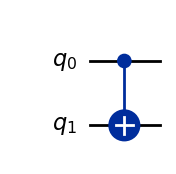

In [25]:
qc=QuantumCircuit(2)
qc.cx(0,1)
qc.draw("mpl")



<div class="alert alert-block alert-info"> <b>Check-in question:</b>

Most gates have the same matrix form in Qiskit as everywhere else. But the CNOT gate acts on two qubits, and so suddenly ordering conventions of qubits becomes an issue. Texts that order qubits $|q_0,q_1,...\rangle$ will show a different matrix form for their CNOT gates. Verify by explicit matrix multiplication that the CNOT matrix above has the correct action on the state $|01\rangle.$

<details>

<summary>Solution:</summary>

$$CNOT|01\rangle =\begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0\end{pmatrix}\begin{pmatrix}0 \\ 1 \\ 0 \\0\end{pmatrix} = \begin{pmatrix}0 \\ 0 \\ 0 \\1\end{pmatrix} = |11\rangle$$


</details>

</div>




**$X$ Gate**: Equivalent to a NOT operation. Single-qubit gate.
$$X|0\rangle = |1\rangle,\\X|1\rangle=|0\rangle$$
$$X=\begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$$

In Qiskit, creating a circuit with an $X$ gate looks like this:

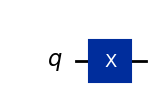

In [3]:
qc=QuantumCircuit(1)
qc.x(0)
qc.draw("mpl")

**$Z$ Gate**: Adds a "phase" to a state (a prefactor, which in the cases of the Z eigenstates $|0\rangle$ and $|1\rangle$ either a 1, or -1, respectively). Single-qubit gate.
$$Z|0\rangle = |0\rangle,\\Z|1\rangle=-|1\rangle$$
$$Z=\begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$$

In Qiskit, creating a circuit with an $Z$ gate looks like this:

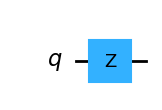

In [4]:
qc=QuantumCircuit(1)
qc.z(0)
qc.draw("mpl")

## 3. Theory

Let's lay out the protocol for quantum teleportation using math. Then, in the next section, we'll realize this setup using a quantum computer.

__Alice and Bob entangle their qubits:__ Initially, Alice's qubit and Bob's qubit are each, separately in the $|0\rangle$ state (a fine assumption and also the correct initialization for IBM quantum computers). We can write this as $|0\rangle_B|0\rangle_A$ or simply as $|00\rangle$. Let's calculate what happens when Alice and Bob act with the Hadamard gate on Alice's qubit, and then a CNOT gate with Alice's qubit as the control and Bob's as the target:

$$\begin{aligned}
CNOT(A,B)H_A |0\rangle_B|0\rangle_A &= CNOT(A,B)|0\rangle_B\frac{1}{\sqrt{2}}\left(|0\rangle_A+|1\rangle_A\right)\\
&=\frac{1}{\sqrt{2}}\left(CNOT(A,B)|0\rangle_B|0\rangle_A+CNOT(A,B)|0\rangle_B|1\rangle_A\right)\\
&=\frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right)
\end{aligned}$$

Note that now Alice's and Bob's qubits are entangled. Although it is not yet determined by nature whether both their qubits are in the $|0\rangle$ state or the $|1\rangle$ state, it is known that their qubits are in the same state.

__Alice and Bob separate:__ The two friends move their qubits to new locations, possibly very far apart. This comes with a lot of caveats: it is not trivial to move quantum information without disturbing it. But it can be moved, and indeed you will move it in this module. But keep in mind as a caveat that we expect to encounter some errors when we move quantum information around a lot.

__Q is introduced:__ The secret state is prepared on qubit Q:

$$
|\psi\rangle_Q = \alpha_0 |0\rangle_Q + \alpha_1 |1\rangle_Q
$$

At this point Q is simply adjacent to Alice's qubit (A). There has been no entanglement, so the quantum state of the three qubits together can be written as:

$$
|\psi\rangle_{AB}|\psi\rangle_Q = \frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right)\left(\alpha_0 |0\rangle_Q + \alpha_1 |1\rangle_Q\right).
$$

The goal is to move the information on Q from Alice's location to the location of Bob. At this point, we are not making any claims or requirements about secrecy or speed of information transfer. We are simply exploring how information can move from Alice to Bob.

Because the information begins on Q, we will assume Q is assigned the lowest number in qubit numbers, such that little endian notation causes Q to be the right-most qubit in the math below.

__Alice entangles qubits A and Q:__ Alice now operates with a CNOT gate with her own qubit as the control and Q as the target, then applies a Hadamard gate to Q.  Let's calculate the three-qubit state after that operation:

$$\begin{aligned}
H_Q CNOT(A,Q)|\psi\rangle_{AB}|\psi\rangle_Q &= H_Q CNOT(A,Q)\frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right)\left(\alpha_0 |0\rangle_Q + \alpha_1 |1\rangle_Q\right)\\
&= H_Q CNOT(A,Q)\frac{1}{\sqrt{2}}\left(\left(\alpha_0 |0\rangle_B|0\rangle_A|0\rangle_Q + \alpha_1 |0\rangle_B|0\rangle_A|1\rangle_Q\right)+\left(\alpha_0 |1\rangle_B|1\rangle_A|0\rangle_Q + \alpha_1 |1\rangle_B|1\rangle_A|1\rangle_Q\right)\right)\\
&= H_Q \frac{1}{\sqrt{2}}\left(\alpha_0 |0\rangle_B|0\rangle_A|0\rangle_Q + \alpha_1 |0\rangle_B|1\rangle_A|1\rangle_Q+\alpha_0 |1\rangle_B|1\rangle_A|0\rangle_Q + \alpha_1 |1\rangle_B|0\rangle_A|1\rangle_Q\right)\\
&= \frac{1}{2}\left(\alpha_0 |0\rangle_B|0\rangle_A|0\rangle_Q + \alpha_0 |0\rangle_B|0\rangle_A|1\rangle_Q + \alpha_1 |0\rangle_B|1\rangle_A|0\rangle_Q-\alpha_1 |0\rangle_B|1\rangle_A|1\rangle_Q\right)\\
&+\frac{1}{2}\left(\alpha_0 |1\rangle_B|1\rangle_A|0\rangle_Q + \alpha_0 |1\rangle_B|1\rangle_A|1\rangle_Q + \alpha_1 |1\rangle_B|0\rangle_A|0\rangle_Q - \alpha_1 |1\rangle_B|0\rangle_A|1\rangle_Q\right)
\end{aligned}$$

Because A and Q are in the same location, let us group the terms above according to the outcomes of measurements on qubits A and Q:
$$\begin{aligned}
|\psi\rangle = \frac{1}{2}\left((\alpha_0 |0\rangle_B+\alpha_1 |1\rangle_B)|0\rangle_A|0\rangle_Q +  (\alpha_0 |0\rangle_B-\alpha_1 |1\rangle_B)|0\rangle_A|1\rangle_Q + (\alpha_1 |0\rangle_B+\alpha_0 |1\rangle_B)|1\rangle_A|0\rangle_Q+ (-\alpha_1 |0\rangle_B+\alpha_0 |1\rangle_B)|1\rangle_A|1\rangle_Q \right)\\
\end{aligned}
$$

<div class="alert alert-block alert-info"> <b>Check-in question:</b> 

Given the expression above for the states of all three qubits, what is the probability that a measurement of qubits A and Q yields $|0\rangle_A|0\rangle_Q?$

<details>

<summary>Answer:</summary>

25%. To see this, recall that Bob's state must be normalized, so
$$ |_A \langle0|_Q\langle0| \frac{1}{2} |0\rangle_A|0\rangle_Q (\alpha_0 |0\rangle_B+\alpha_1 |1\rangle_B)|^2 = \frac{1}{4}|(\alpha_0 |0\rangle_B+\alpha_1 |1\rangle_B)|^2 = \frac{1}{4}$$


</details>

</div>

Now, Alice can measure qubits A and Q . She cannot control the outcome of that measurement, since quantum measurements are probabilistic. So when she measures, there are 4 possible outcomes and all 4 are equally likely: $|0\rangle_A|0\rangle_Q,$ $|0\rangle_A|1\rangle_Q,$ $|1\rangle_A|0\rangle_Q,$ and $|1\rangle_A|1\rangle_Q.$ Note that each outcome has different implications for Bob's qubit. For example, if Alice finds her qubits to be in $|0\rangle_A|0\rangle_Q,$ that has collapsed the entire, 3-qubit quantum state to $(\alpha_0|0\rangle_B+\alpha_1|1\rangle_B)|0\rangle_A|0\rangle_Q.$ Other measurement outcomes for Alice yield different states for Bob. These are collected together in the table below.



| Alice outcome | Bob's state  | Instruction to Bob| Result |
| ----------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------- | -------------------------|
| $ \vert 0\rangle_A \vert 0\rangle_Q$ |     $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$        |        None           | $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$| 
| $ \vert 0\rangle_A \vert 1\rangle_Q$ |     $\alpha_0\vert 0\rangle_B-\alpha_1\vert 1\rangle_B$        |        $Z$           |  $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$| 
| $ \vert 1\rangle_A \vert 0\rangle_Q$ |     $\alpha_1\vert 0\rangle_B+\alpha_0\vert 1\rangle_B$       |        $X$           |  $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$| 
| $ \vert 1\rangle_A \vert 1\rangle_Q$ |     $-\alpha_1\vert 0\rangle_B+\alpha_0\vert 1\rangle_B$       |        $X$ then $Z$           | $\alpha_0\vert 0\rangle_B+\alpha_1\vert 1\rangle_B$|

For all the possible measurement outcomes on Alice's qubits, Bob's qubit is left in a state vaguely resembling the secret state originally on Q. In the case where Alice measures $|0\rangle_C|0\rangle_A$ (the first row of the table), Bob's qubit is left in exactly the secret state! In the other cases, there is something off about the state. The coefficients ($\alpha$'s) are swapped, or there is a "-" sign where there should be a "+" sign, or both. In order to modify Bob's qubit to make it exactly equal to the secret state, Alice must call Bob (use some means of classical communication) and tell Bob to perform additional operations on his qubit, as outlined in the table. For example, in the third row the coefficients are swapped. If Alice calls Bob and tells him to apply an $X$ gate to his qubit, it changes a $|0\rangle$ to a $|1\rangle$ and vice-versa, and out comes the secret state.

It should now be clear why we can't use this setup to send information faster than light. We might get lucky and measure $|0\rangle_A|0\rangle_Q,$ meaning Bob has exactly the secret state, instantly. But Bob doesn't know that until we call him and tell him "We measured $|0\rangle_A|0\rangle_Q$, so you don't have to do anything."

In the thought experiment, the qubits are often physically separated and taken to a new location. IBM quantum computers use solid-state qubits on a chip that can't be separated. So instead of moving Alice and Bob to different locations, we will separate the information on the chip itself by using so-called "swap gates" to move the information from one qubit to another. 

## 4. Experiment 1: Basic teleportation

IBM Quantum recommends tackling quantum computing problems using a framework we call "Qiskit Patterns". It consists of the following steps.
- Step 1: Map your problem to a quantum circuit
- Step 2: Optimize your circuit for running on real quantum hardware
- Step 3: Execute your job on IBM quantum computers using Runtime Primitives
- Step 4: Post-process the results

### 4.1. Step 1: Map your problem to a quantum circuit

All the math we did above was outlining step 1. We will implement it now, building our quantum circuit using Qiskit! We start creating a quantum circuit with three qubits, and entangling the two qubits of Alice and Bob. We will take these to be qubits 1 and 2, and we will reserve qubit 0 for the secret state.

Saved color circuit diagram to report/img/teleportation_circuit_color.png
Saved grayscale circuit diagram to report/img/teleportation_circuit_grayscale.png


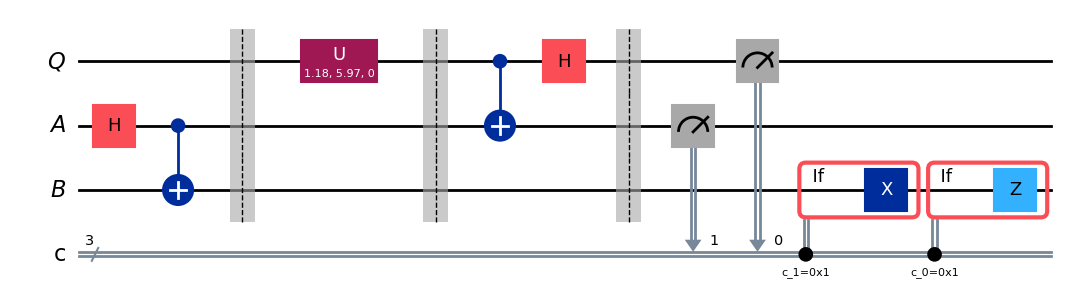

In [43]:
# Step 1: Map your problem to a quantum circuit

# Import some general packages
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import random
import numpy as np
from numpy import pi

# Define registers
secret = QuantumRegister(1, "Q")
Alice = QuantumRegister(1, "A")
Bob = QuantumRegister(1, "B")

cr = ClassicalRegister(3, 'c')

qc = QuantumCircuit(secret, Alice, Bob, cr)

# We entangle Alice's and Bob's qubits as in our work above. We apply a Hadamard gate and then a CNOT gate.
# Note that the second argument in the CNOT gate is the target.
qc.h(Alice)
qc.cx(Alice,Bob)

# Inserting a barrier changes nothing about the logic. It just allows us to force gates to be positioned in "layers".
qc.barrier()

# Now we will use random variables to create the secret state. Don't worry about the "u" gate and the details. 
np.random.seed(42) #fixing seed for repeatibility
theta = np.random.uniform(0.0, 1.0) * np.pi    #from 0 to pi
varphi = np.random.uniform(0.0, 2.0) * np.pi    #from 0 to 2*pi

# Assign the secret state to the qubit on the other side of Alice's (qubit 0), labeled Q
qc.u(theta, varphi, 0.0, secret)
qc.barrier()

# Now entangle Q and Alice's qubits as in the discussion above.
qc.cx(secret,Alice)
qc.h(secret)
qc.barrier()

# Now Alice measures her qubits, and stores the outcomes in the "classical registers" cr[]
qc.measure(Alice, cr[1])
qc.measure(secret, cr[0])

# Now we insert some conditional logic. If Alice measures Q in a "1" we need a Z gate, and if Alice measures A in a "1" we need an X gate (see the table).
with qc.if_test((cr[1], 1)):
    qc.x(Bob)
with qc.if_test((cr[0], 1)):   
    qc.z(Bob)

qc.draw(output="mpl")
save_circuit_diagram(qc, "teleportation_circuit")

That's all we have to do to get Alice's state teleported to Bob. However, recall that when we measure a quantum state $\alpha_0 |0\rangle+\alpha_1|1\rangle$ we find either $|0\rangle$ or $|1\rangle.$ So at the end of all this, Bob definitely has Alice's secret state, but we can't easily verify this with a measurement. In order for a measurement to tell us that we did this correctly, we have to do a trick. We had an operator labeled "U" for "unitary" which we used to prepare Alice's secret state. We can apply the inverse of U at the end of our circuit. If U mapped Alice's $|0\rangle$ state into $\alpha_0 |0\rangle+\alpha_1|1\rangle$, then the inverse of U will map Bob's $\alpha_0 |0\rangle+\alpha_1|1\rangle$ back to $|0\rangle.$ So this last part wouldn't necessarily be done if the goal were just to move quantum information. This is only done for us to check ourselves.

Saved color circuit diagram to report/img/teleportation_circuit_validation_color.png
Saved grayscale circuit diagram to report/img/teleportation_circuit_validation_grayscale.png


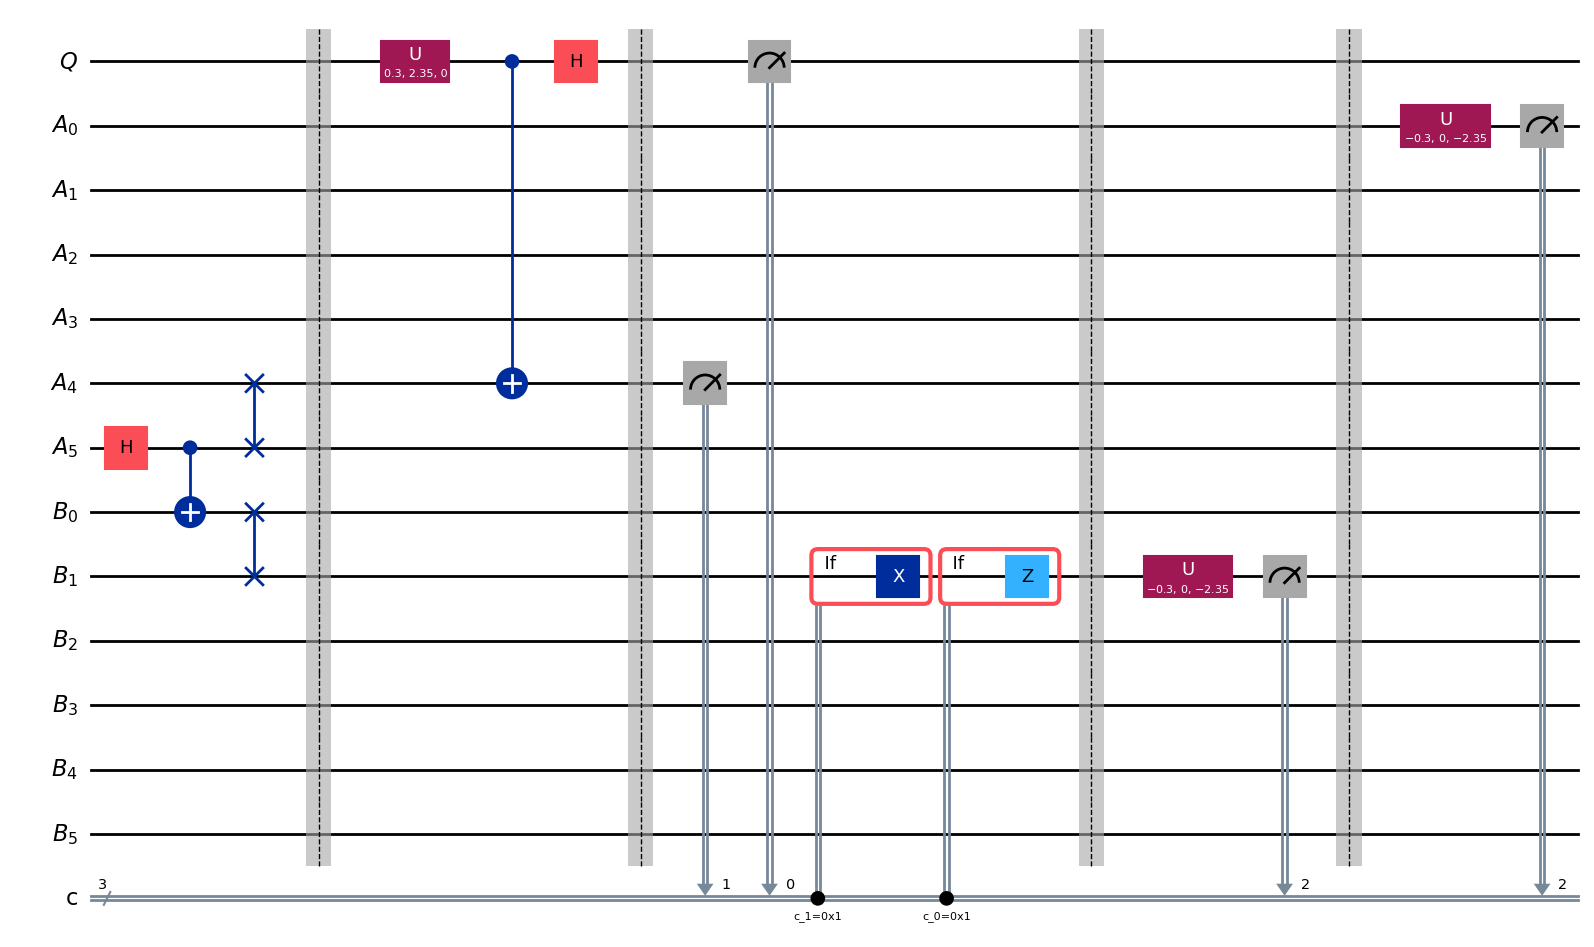

In [42]:
# Add the inverse of U and measure Bob's qubit.
qc.barrier()

qc.u(theta, varphi, 0.0, Bob).inverse()    # inverse of u(theta,varphi,0.0)
qc.measure(Bob, cr[2]) # add measurement gate

qc.draw(output="mpl")
save_circuit_diagram(qc, "teleportation_circuit_validation")

So if we've done this correctly, our measurement on Bob's qubit should yield a $|0\rangle$ state. Of course, these measurements are probabilistic. So if there is even a small chance of measuring Bob's qubit to be in the $|1\rangle$ state, then a single measurement could result in $|1\rangle.$ We would really want to make many measurements to be assured that the probability of $|0\rangle$ is quite high.

### 4.2. Step 2: Optimize problem for quantum execution

This step takes the operations we want to perform and expresses them in terms of the functionality of a specific quantum computer. It also maps our problem onto the layout of the quantum computer.

We will start by loading several packages that are required to communicate with IBM quantum computers. We must also select a backend on which to run. We can either choose the least busy backend, or select a specific backend whose properties we know.

In [20]:
#Load the Qiskit Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

#Use the least busy backend, or uncomment the loading of a specific backend like "ibm_brisbane".
backend = service.least_busy(operational=True, simulator=False, min_num_qubits = 127)
#backend = service.backend("ibm_brisbane")
print(backend.name)

ibm_brisbane


Now we must "transpile" the quantum circuit. This involves many sub-steps and is a fascinating topic. Just to give an example of a sub-step: not all quantum computers can directly implement all logical gates in Qiskit. We must write the gates from our circuit in terms of gates the quantum computer can implement. We can carry out that process, and others, using a preset pass manager. Setting ```optimization = 3``` (the highest level of optimization) ensures that the mapping from our abstract quantum circuit to the instructions given to the quantum computer is as efficient as our pre-processing can get it.

In [21]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)

A "sampler" is a primitive designed to sample possible states resulting from a quantum circuit, and collect statistics on what states might be measured and with what probability. We import the Qiskit Runtime sampler here:

In [22]:
# Load the Runtime primitive and session
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode = backend)

Not all computations on a quantum computer can be reasonably simulated on classical computers. This simple teleportation definitely can be, but it isn't at all surprising that we can classically save information in one place or another. We strongly recommend carrying out these calculations using a real IBM quantum computer. But in case you have exhausted your free monthly use, or if something must be completed in class and can't wait in the queue, this module can be completed using a simulator. To do this, simply run the cell below and uncomment the associated lines in the "Execute" steps.

In [23]:
# Load the backend sampler
from qiskit.primitives import BackendSamplerV2

# Load the Aer simulator and generate a noise model based on the currently-selected backend.
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(backend)

# Define a simulator using Aer, and use it in Sampler.
backend_sim = AerSimulator(noise_model=noise_model)
sampler_sim = BackendSamplerV2(backend = backend_sim)

# Alternatively, load a fake backend with generic properties and define a simulator.
from qiskit.providers.fake_provider import GenericBackendV2
backend_gen = GenericBackendV2(num_qubits=18)
sampler_gen = BackendSamplerV2(backend = backend_gen)

### 4.3. Step 3: Execute

Use the sampler to run your job, with the circuit as an argument.

In [24]:
job = sampler.run([qc_isa])
#job = sampler_sim.run([qc_isa])
res=job.result()
counts=res[0].data.c.get_counts()

#job = sampler_gen.run([qc_isa])
#res=job.result()
#counts=res[0].data.c.get_counts()

### 4.4. Step 4: Post-processing and analysis

Let's plot the results and interpret them.

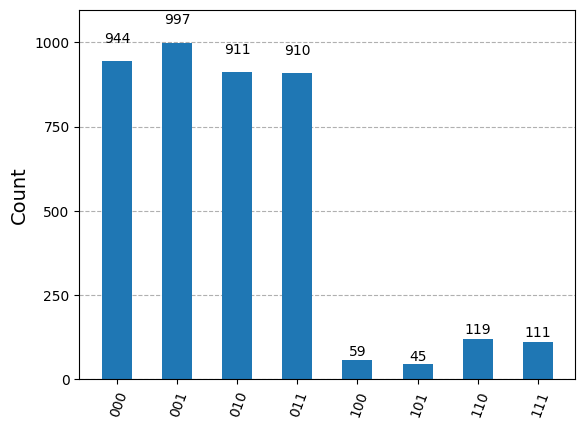

In [25]:
# This required 5 s to run on ibm_torino on 10-28-24
from qiskit.visualization import plot_histogram
plot_histogram(counts)


<div class="alert alert-block alert-info"> <b>Check-in question:</b> 

Which of the states above indicate successful teleportation, and how can you tell?

<details>

<summary>Answer:</summary>

The states $|000\rangle,$ $|001\rangle,$ $|010\rangle,$ $|011\rangle$ are all consistent with successful teleportation. This is because we added a gate to undo the initial preparation of the secret state. If the secret state was successfully teleported to Bob's qubit, that additional gate should return Bob's qubit to the $|0\rangle$ state. So any state above with Bob's qubit (qubit 0, also measured to the 0th component of the classical register, and hence the highest/right-most) in the $|0\rangle$ state indicates success.


</details>

</div>

This plot is showing all measurement outcomes for the three qubits, over 5,000 trials or "shots". We pointed out earlier that Alice would measure all possible states for qubits A and Q with equal likelihood. We assigned qubits 0-2 in the circuit to Q, A, and B, in that order. In little-endian notation, Bob's qubit is the left-most/lowest. So the four bars on the left correspond to Bob's qubit being $|0\rangle$, and the other two qubits being in all possible combinations with roughly equal probability. Note that almost all (usually \~95%) of measurements yield Bob's qubit in the $|0\rangle$ state, meaning our setup was successful! There are a handful of shots (\~5%) that yielded Bob's qubit in the $|1\rangle$ state. That should not logically be possible. However, all modern quantum computers suffer from noise and errors to a much greater extent than classical computers. And quantum error correction is still an emerging field.


## 5. Experiment 2: Teleporting across a processor

Arguably, the most interesting part of quantum teleportation is that a quantum state can be teleported over long distances instantly (though the classical communication of extra gates is not instant). As already stated, we can't break qubits off the processor and move them around. But we can move the information from one qubit to another, until the qubits involved in teleportation are on opposite sides of the processor. Let us repeat the steps we took above, but now we will make a larger circuit with enough qubits to span the processor.

### 5.1. Step 1: Map your problem to a quantum circuit

This time, the qubits corresponding to Alice and Bob will change. So we will not name a single qubit "A" and another "B". Rather, we will number the qubits and use variables to represent the current position of the information on qubits belonging to Alice and Bob. All other steps except the swap gates are as described previously.

Saved color circuit diagram to report/img/teleportation_circuit_swap_color.png
Saved grayscale circuit diagram to report/img/teleportation_circuit_swap_grayscale.png


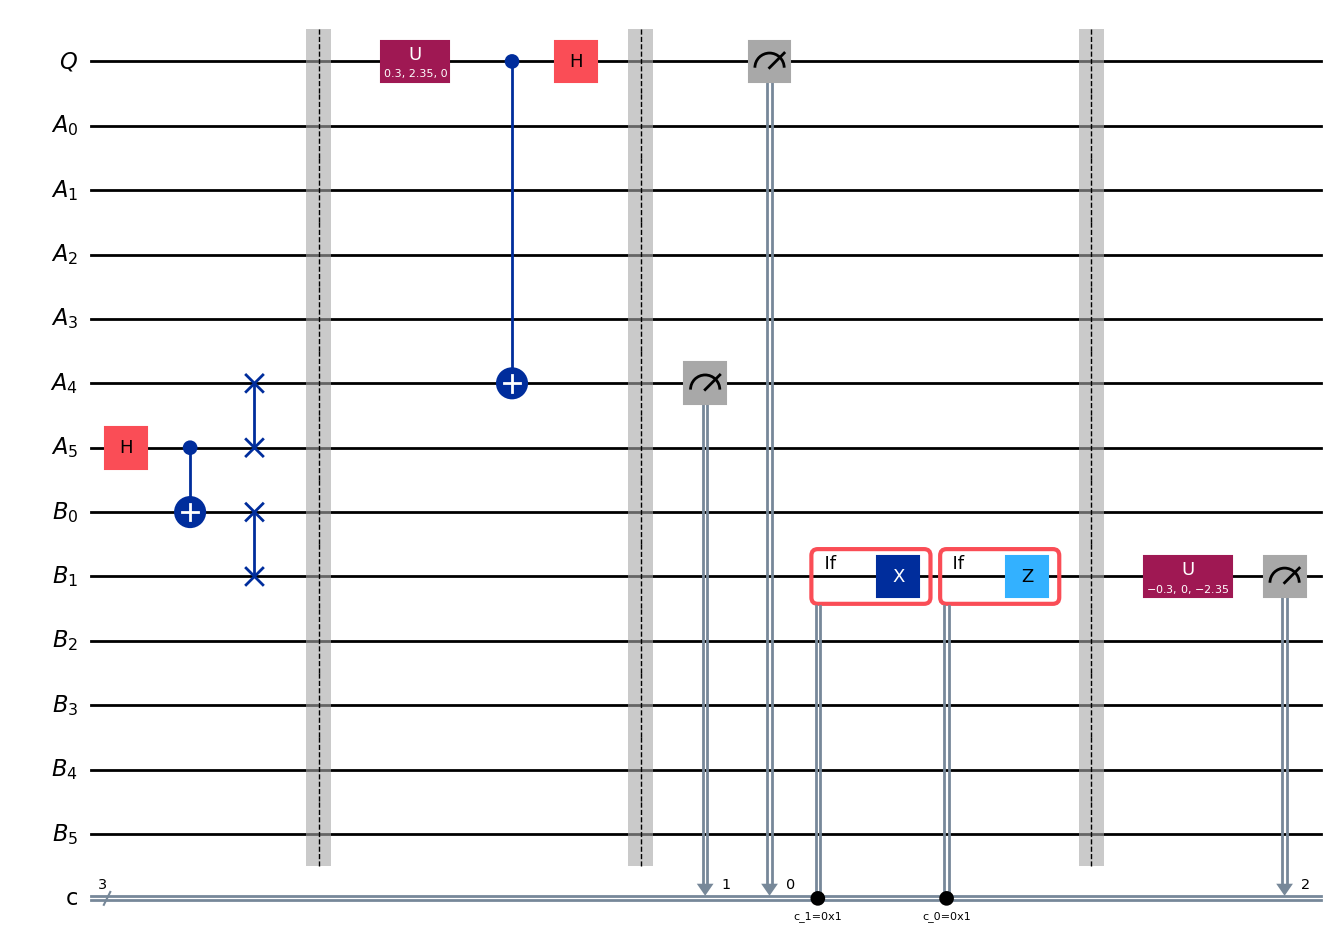

In [41]:
# Step 1: Map

# Define registers
qr = QuantumRegister(13, 'q')

qc = QuantumCircuit(qr, cr)

# Define registers
secret = QuantumRegister(1, "Q")
ebitsa = QuantumRegister(6, "A")
ebitsb = QuantumRegister(6, "B")
#q = ClassicalRegister(1, "q meas")
#a = ClassicalRegister(1, "a")
#b = ClassicalRegister(1, "b")
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(secret, ebitsa, ebitsb, cr)

# We'll start Alice in the middle of the circuit, then move information outward in both directions.
Alice = 5
Bob = 0
qc.h(ebitsa[Alice])
qc.cx(ebitsa[Alice],ebitsb[Bob])

# Starting with Bob and Alice in the center, we swap their information onto adjacent qubits, until the information is on distant qubits.

for n in range(1, 2):
    qc.swap(ebitsb[Bob],ebitsb[Bob+1])
    qc.swap(ebitsa[Alice],ebitsa[Alice-1])
    Alice = Alice-1
    Bob = Bob+1

qc.barrier()

# Create a random state for Alice (qubit zero)
np.random.seed(42) #fixing seed for repeatibility
#theta = np.random.uniform(0.0, 1.0) * np.pi    #from 0 to pi
theta = 0.3
varphi = np.random.uniform(0.0, 2.0) * np.pi    #from 0 to 2*pi


qc.u(theta, varphi, 0.0, secret)

# Entangle Alice's two qubits
qc.cx(secret,ebitsa[Alice])
qc.h(secret)

qc.barrier()

# Make measurements of Alice's qubits and store the results in the classical register.
qc.measure(ebitsa[Alice], cr[1])
qc.measure(secret, cr[0])

# Send instructions to Bob's qubits based on the outcome of Alice's measurements.
with qc.if_test((cr[1], 1)):
    qc.x(ebitsb[Bob])
with qc.if_test((cr[0], 1)):   
    qc.z(ebitsb[Bob])

qc.barrier()

# Invert the preparation we did for Carl's qubit so we can check whether we did this correctly.
qc.u(theta, varphi, 0.0, ebitsb[Bob]).inverse()    # inverse of u(theta,varphi,0.0)
qc.measure(ebitsb[Bob], cr[2]) # add measurement gate

qc.draw('mpl')
save_circuit_diagram(qc, "teleportation_circuit_swap")

You can see in the circuit diagram that the logical steps are the same. The only difference is that we used the swap gates to bring Alice's qubit's state from qubit 6 ($A_5$) up to qubit 1 ($A_0$), right next to Q. And we used swap gates to bring Bob's initial state from qubit 7 ($B_0$) down to qubit 12 ($B_5$). Note that the state on qubit 12 is not even related to Q's secret state until measurements are made on the distant qubits 0 and 1, and the state on qubit 12 is not equal to the secret state until after the conditional $X$ and $Z$ gates are applied.

### 5.2.  Step 2: Optimize your circuit

Normally, when we use the pass manager to transpile and optimize our circuits, it makes sense to set ```optimization_level = 3```, because we want our circuits to be as efficient as possible. In this case, there is no computational reason for us to transfer states from qubits 6 and 7 over to qubits 1 and 12. That was just something we did to demonstrate teleportation over a distance. If we ask the pass manager to optimize our circuit, it will realize there is no logical reason for these swap gates, and it will remove them and carry out the gate operations on adjacent qubits. So for this special case, we use ```optimization_level = 0```.

In [27]:
# Step 2: Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pmzero = generate_preset_pass_manager(target=target, optimization_level=0)

qc_isa_zero = pmzero.run(qc)

print(qc_isa_zero.depth())

99


We can visualize where on the quantum processor these qubits are using the ```plot_circuit_layout``` function.

### 5.3 Step 3: Run

As before, we recommend running on real IBM quantum computers. If your monthly free usage has been reached, feel free to uncomment the simulator cells to run on a simulator. 

In [28]:
# This required 5 s to run on ibm_torino on 10-28-24
job = sampler.run([qc_isa_zero])
#job = sampler_sim.run([qc_isa_zero])
counts=job.result()[0].data.c.get_counts()

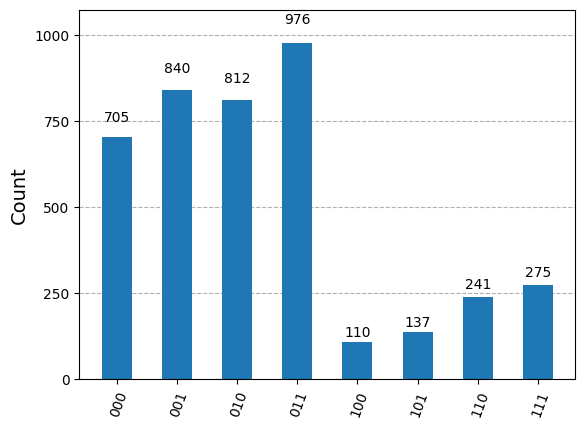

In [29]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

### 5.4. Step 4: Classical post-processing

Again we see that the probabilities for the possible outcomes for Alice's qubits are fairly uniform. There is a strong preference for finding Bob's qubit in $|0\rangle$ after inverting the secret code, meaning there is a strong probability that we correctly teleported the secret state across the processor from Q to Bob (qubits 0 to 12). However, we note that there is now about a higher chance of *not* measuring $|0\rangle$ for Bob. This is an important lesson in quantum computing: the more gates you have, especially multi-qubit gates like swap gates, the more noise and errors you will encounter.

## 6. Review and questions:

### Critical concepts:

- Qubits can be entangled, meaning a measurement of one qubit affects or even determines the state of another qubit.
- Entanglement differs from classical correlations; for example, qubits A and B could be in a superposition of states like $\alpha_0|00\rangle+\alpha_1|11\rangle.$ The state of A or B could be undetermined by nature, and yet A and B could still be guaranteed to be in the same state.
- Through a combination of entanglements and measurements, we can transfer a state (which can store information) from one qubit to another. This transfer can even be done over long distances, and this is called quantum teleportation.
- Quantum teleportation relies on quantum measurements, which are probabilistic. Thus, classical communication can be necessary to tweak the teleported states. This prevents quantum teleportation from moving information faster than light. Quantum teleportation does not violate relativity or causality.
- Modern quantum computers are more susceptible to noise and errors than classical computers. Expect a few percent error.
- The more gates you add in sequence (especially 2-qubit gates) the more errors and noise you can expect.


### T/F Questions:

1. T/F Quantum teleportation can be used to send information faster than light.
2. T/F Modern evidence suggests that the collapse of a quantum state propagates faster than light.
3. T/F In Qiskit, qubits are ordered in states with the lowest-numbered qubit on the right, as in $|q_3,q_2,q_1, q_0\rangle$


### MC Questions:

1. Qubits A and B are entangled, then separated by a great distance $d$. Qubit A is measured. Which statement is correct about the speed at which the state of qubit B is affected?

- a. Qubit B is affected instantly, within experimental tolerance, in experiments run so far. 
- b. Qubit B is affected after a time $d/c$, meaning the quantum state "collapses" at approximately the speed of light, within experimental tolerance.
- c. Qubit B is affected only after classical communication has occurred, meaning it happens in a time longer than $d/c$. 
- d. None of the above

2. Recall that measurement probability is related to amplitudes in quantum states. For example, if a qubit is initially in the state $\alpha_0|0\rangle+\alpha_1 |1\rangle,$ the probability of measuring the state $|0\rangle$ is $|\alpha_0|^2.$ Not all sets of measurements will exactly match these probabilities, due to finite sampling (just as flipping a coin might yield heads twice in a row). The measurement histogram below could correspond to which of the following quantum states? Select the best option.

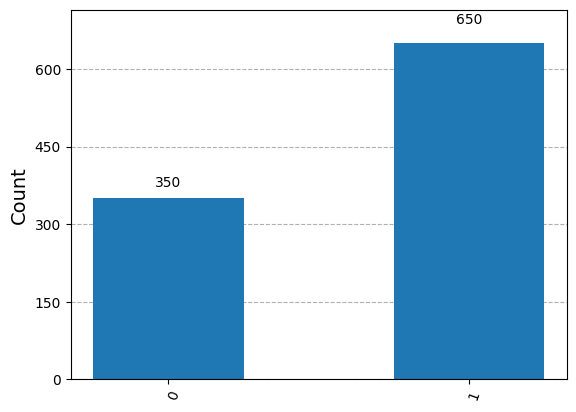

- a. $|0\rangle$
- b. $\frac{1}{\sqrt{2}}\left(|0\rangle-|1\rangle\right)$
- c. $\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$
- d. $\frac{4}{5}|0\rangle+\frac{3}{5}|1\rangle$
- e. $\frac{3}{5}|0\rangle+\frac{4}{5}|1\rangle$


3. Which of the following states show(s) qubits A and B entangled? Select all that apply.
- a. $\frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right)$
- b. $\frac{4}{5}|0\rangle_B|0\rangle_A+\frac{3}{5}|1\rangle_B|1\rangle_A$
- c. $\frac{1}{\sqrt{2}}\left(|0\rangle_B|1\rangle_A-|1\rangle_B|0\rangle_A\right)$
- d. $\frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|0\rangle_A\right)$
- e. $|0\rangle_B|0\rangle_A$

4. In this module, we prepared an entangled state: $\frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right).$ But there are many other entangled states one could use for a similar protocol. Which of the states below could yield a 2-qubit measurement histogram like the following? Select the best response.

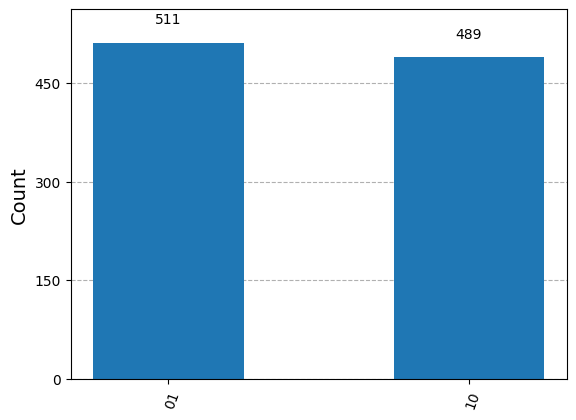

- a. $\frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right)$
- b. $\frac{4}{5}|0\rangle_B|0\rangle_A+\frac{3}{5}|1\rangle_B|1\rangle_A$
- c. $\frac{1}{\sqrt{2}}\left(|0\rangle_B|1\rangle_A-|1\rangle_B|0\rangle_A\right)$
- d. $\frac{4}{5}|0\rangle_B|1\rangle_A+\frac{3}{5}|1\rangle_B|0\rangle_A$
- e. $|0\rangle_B|0\rangle_A$

### Discussion Questions:

1. Describe the quantum teleportation protocol, from start to finish, to your partner/group. See if they have anything to add, or if they have questions.

2. Is there anything unique about the initial entangled state between Alice and Bob: $\frac{1}{\sqrt{2}}\left(|0\rangle_B|0\rangle_A+|1\rangle_B|1\rangle_A\right)?$ If so, what is unique about it? If not, what other entangled states could we have used?
